<a href="https://colab.research.google.com/github/kholeigh/Graudate-Capstone/blob/main/Predicting_Adult_Arrest_Quasi_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import necessary libraries

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report




In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [ ]:
#load dataset into colab
top_3_arrests = pd.read_csv('/content/drive/MyDrive/Adult_Arrests.csv')

<ipython-input-4-478767af197f>:2: DtypeWarning: Columns (7,20,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  top_3_arrests = pd.read_csv('/content/drive/MyDrive/Adult_Arrests.csv')


In [ ]:
print(top_3_arrests.dtypes)  # Check column data types
print(top_3_arrests.iloc[:, [7, 20, 27, 28]])  # View the problematic columns


TYPE                   object
YEAR                    int64
DATE_                  object
HOUR                    int64
CCN                    object
ARREST_NUMBER          object
AGE                     int64
DEFENDANT_PSA          object
DEFENDANT_DISTRICT     object
RACE                   object
ETHNICITY              object
SEX                    object
CATEGORY               object
DESCRIPTION            object
ARREST_PSA            float64
ARREST_DISTRICT        object
ARREST_BLOCKX         float64
ARREST_BLOCKY         float64
OFFENSE_BLOCKY        float64
OFFENSE_BLOCKX        float64
OFFENSE_PSA            object
OFFENSE_DISTRICT       object
ARREST_LATITUDE       float64
ARREST_LONGITUDE      float64
OFFENSE_LATITUDE      float64
OFFENSE_LONGITUDE     float64
GIS_ID                 object
CREATOR                object
CREATED                object
EDITOR                 object
EDITED                 object
GLOBALID               object
OBJECTID                int64
dtype: obj

In [ ]:
# Define the problematic columns to drop
problematic_columns = ['DEFENDANT_PSA', 'OFFENSE_PSA', 'CREATOR', 'CREATED']

# Drop the problematic columns
top_3_arrests = top_3_arrests.drop(columns=problematic_columns, errors='ignore')

# Confirm the changes
print(top_3_arrests.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259875 entries, 0 to 259874
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   TYPE                259875 non-null  object 
 1   YEAR                259875 non-null  int64  
 2   DATE_               259875 non-null  object 
 3   HOUR                259875 non-null  int64  
 4   CCN                 259832 non-null  object 
 5   ARREST_NUMBER       259875 non-null  object 
 6   AGE                 259875 non-null  int64  
 7   DEFENDANT_DISTRICT  225022 non-null  object 
 8   RACE                259875 non-null  object 
 9   ETHNICITY           213976 non-null  object 
 10  SEX                 259875 non-null  object 
 11  CATEGORY            259863 non-null  object 
 12  DESCRIPTION         259834 non-null  object 
 13  ARREST_PSA          258224 non-null  float64
 14  ARREST_DISTRICT     258285 non-null  object 
 15  ARREST_BLOCKX       257849 non-nul

Estimated Treatment Effect (ATE): 14.093674030698253


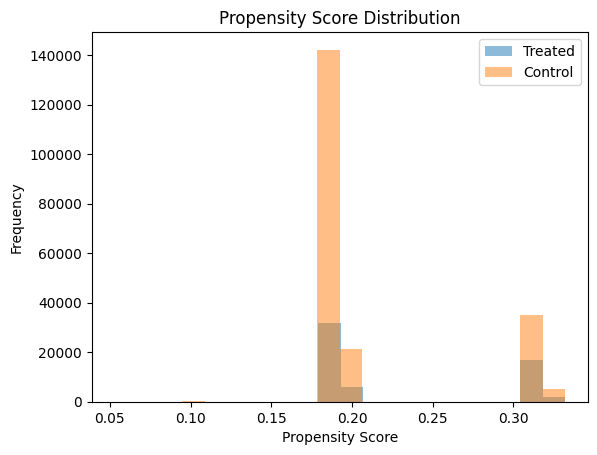

In [ ]:


# Step 1: Define the dataset
label_encoder = LabelEncoder()

# Encode categorical variables
top_3_arrests['RACE'] = label_encoder.fit_transform(top_3_arrests['RACE'])
top_3_arrests['SEX'] = label_encoder.fit_transform(top_3_arrests['SEX'])
top_3_arrests['CATEGORY'] = label_encoder.fit_transform(top_3_arrests['CATEGORY'])

# Step 2: Define treatment (Simple Assault as treated group)
top_3_arrests['TREATED'] = (top_3_arrests['CATEGORY'] == label_encoder.transform(['Simple Assault'])[0]).astype(int)

# Step 3: Define features (RACE and SEX) and the treatment variable
X = top_3_arrests[['RACE', 'SEX']]  # Features
T = top_3_arrests['TREATED']       # Treatment indicator

# Step 4: Estimate propensity scores using logistic regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X, T)
top_3_arrests['PROPENSITY_SCORE'] = log_reg.predict_proba(X)[:, 1]

# Step 5: Match treated and control groups using propensity scores
treated = top_3_arrests[top_3_arrests['TREATED'] == 1]
control = top_3_arrests[top_3_arrests['TREATED'] == 0]

# Use nearest neighbor matching based on propensity scores
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(control[['PROPENSITY_SCORE']])
distances, indices = nn.kneighbors(treated[['PROPENSITY_SCORE']])
matched_control = control.iloc[indices.flatten()]

# Combine treated and matched control
matched_data = pd.concat([treated, matched_control])

# Step 6: Evaluate treatment effect
# Compare outcomes between treated and matched control groups
treated_mean = matched_data[matched_data['TREATED'] == 1]['CATEGORY'].mean()
control_mean = matched_data[matched_data['TREATED'] == 0]['CATEGORY'].mean()

treatment_effect = treated_mean - control_mean
print(f"Estimated Treatment Effect (ATE): {treatment_effect}")

# Step 7: Optional - Visualize propensity score distributions
import matplotlib.pyplot as plt

plt.hist(treated['PROPENSITY_SCORE'], bins=20, alpha=0.5, label='Treated')
plt.hist(control['PROPENSITY_SCORE'], bins=20, alpha=0.5, label='Control')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.title('Propensity Score Distribution')
plt.legend()
plt.show()
